In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import time
import torch.nn as nn

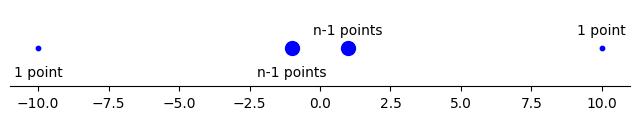

In [119]:
x= [-10,-1,1,10]
y1=[1]*4
y = [1]*2
labels=["1 point", "n-1 points", "n-1 points", "1 point"]

fig, ax = plt.subplots(figsize=(8, 1))

ax.scatter([-10, 10], y, s=10, color="blue")
ax.scatter([-1, 1], y, s=100, color="blue")
ax.scatter([0,0],[0,2],color="white")

for xi, yi, label in zip(x, y1, labels):
    ax.text(xi, yi + 0.7*(xi>0) - 0.5*(xi<0), label, ha="center", va="top", fontsize=10, color="black")

# ax.spines["bottom"].set_position(("data", 0))
ax.spines["bottom"].set_visible(True)   # keep x-axis line

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.yaxis.set_visible(False)  # hide y-axis scale and ticks
# ax.xaxis.set_visible(True)   # keep x-axis scale and ticks



# for xi, yi, label in zip(x, y, labels):
    # plt.text(xi, yi - 0.2, label, ha="center", va="top", fontsize=10, color="black")


plt.show()

In [59]:
NB_EPOCH = 150
TIME_LIM = None # 25
BATCH_SIZE = 64


REPEAT_TIMES = 10

In [3]:
def make_2d_classification(N=4000, well_split=True):
    a_pos1 = torch.randn(N//4, 2) + torch.tensor([3.0, 2.0])
    a_pos2 = torch.randn(N//4, 2) + torch.tensor([-3.0, 3.0])
    if well_split:
        a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -5.0])
    else:
        a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -2.0])
    data = torch.cat([a_pos1, a_pos2, a_neg], dim=0)
    data = (data - data.mean(axis=0)) / np.sqrt(data.var(axis=0))
    labels = torch.cat([torch.ones(N//2), torch.zeros(N//2)])
    return TensorDataset(data, labels)

In [4]:
# cifar_classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# from https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose(
    # [transforms.ToTensor(),
    #  transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True,
                                      download=True, 
                                      #transform=transform
                                      )

testset = torchvision.datasets.MNIST(root='./data', 
                                     train=False,
                                     download=True,
                                     #transform=transform
                                     )

In [6]:
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler

def filter_classes_MNIST(dataset, classes_to_keep):

    # Get data and targets
    data = dataset.data.flatten(start_dim=1)
    targets = dataset.targets

    # Create mask
    mask = (targets == classes_to_keep[0]) | (targets == classes_to_keep[1])

    # Apply mask
    # filtered_data = (data[mask] / 255).float()
    
    scaler = StandardScaler()
    filtered_data = torch.from_numpy(scaler.fit_transform(data[mask])).float()

    # filtered_data = (filtered_data - filtered_data.mean(axis=0)) / np.sqrt(filtered_data.var(axis=0))

    label_map = {classes_to_keep[0]: 0, classes_to_keep[1]: 1}
    filtered_targets = torch.tensor([label_map[t.item()] for t in targets[mask]])

    return TensorDataset(filtered_data, filtered_targets)

In [7]:
mnist_01_train = filter_classes_MNIST(trainset, [0,1])
# mnist_01_test = filter_classes_MNIST(testset, [0,1])

In [8]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

In [9]:
# check https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
# check https://github.com/shaoanlu/dogs-vs-cats-redux/blob/master/opt_experiment.ipynb

In [10]:
from sklearn.datasets import make_blobs

# torch.manual_seed(42)
# np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 20
DATASET_CLUSTER_COUNT = 5

def blob_dataset():
    clustered_data, _ = make_blobs(n_samples=DATASET_SIZE, 
                                n_features=DATASET_DIM,
                                centers=DATASET_CLUSTER_COUNT,
                                #random_state=42
                                )

    data = torch.from_numpy(clustered_data.astype(np.float32))
    labels = torch.zeros(DATASET_SIZE)
    return TensorDataset(data, labels)

In [11]:
from cluster_tools import kmeans_elbow_aux, ClusterSampler, logistic_label_01_process

Samplers

In [12]:
LAMBDA = 1e-4 # L2 regularization

class SimpleModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=True)
        self.layer.weight.data.fill_(0)
        self.layer.bias.data.fill_(0)
    
    def forward(self, ai):
        return self.layer(ai)

def log_01_criterion(pred, labels):
    l = labels.view(-1, 1)*2 - 1
    return (nn.functional.softplus(-l*pred)).mean()

In [13]:
from sklearn.datasets import load_svmlight_file
import warnings

def load_svm_classif_tensor(filename, process=None):
    X, y = load_svmlight_file(filename)
    X = torch.tensor(X.toarray(), dtype=torch.float32)

    scaler = StandardScaler()
    scaled_X = torch.from_numpy(scaler.fit_transform(X)).float()

    y = torch.tensor(y, dtype=torch.int32)
    if process is not None: # converts the other possible label types to 0/1
        if process == "1 2":
            y -= 1
        elif process == "+-1":
            y = (y + 1)/2
        else:
            warnings.warn("process should be one of '1 2' or '+-1'", UserWarning)
    return TensorDataset(scaled_X, y)

In [34]:
dataset = load_svm_classif_tensor("./data/phishing_dataset.txt") #make_2d_classification(well_split=True) 
clustered_data, full_labels = dataset.tensors
labeled_data = logistic_label_01_process(dataset)

In [36]:
# probably utils function
from utils import dimension_reduction

compressed_data = dimension_reduction(clustered_data, alg="pca")

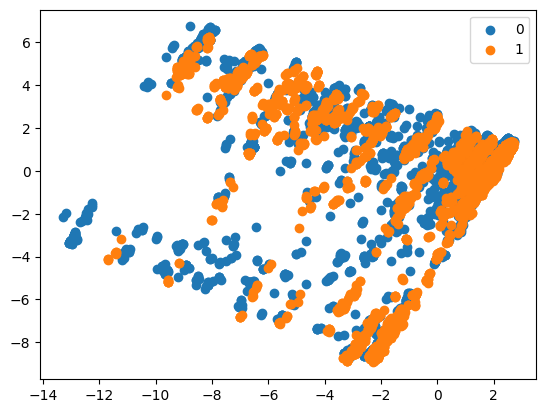

In [37]:
compressed_labeled = dimension_reduction(labeled_data, alg="pca")
mask_0 = (full_labels == 0)
mask_1 = (full_labels == 1)
plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], label="0")
plt.scatter(compressed_data[mask_1,0], compressed_data[mask_1,1], label="1")
plt.legend()
plt.show()

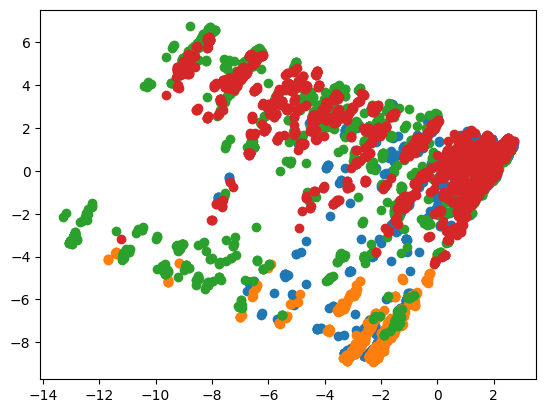

In [38]:
from cluster_tools import get_clusters

kmeans_clusters = get_clusters(dataset, logistic_label_01_process)

cluster_sampler = ClusterSampler(N, BATCH_SIZE, kmeans_clusters)
for i in range(cluster_sampler.cluster_count):
    selected = compressed_data[cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

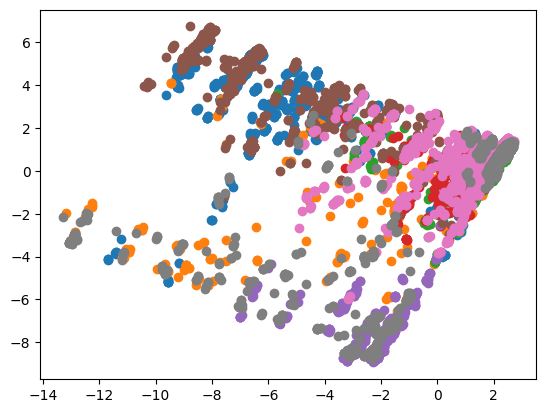

In [39]:
from cluster_tools import kmeans_cos_elbow

cos_clusters = get_clusters(dataset, logistic_label_01_process, kmeans_cos_elbow)
cosine_cluster_sampler = ClusterSampler(N, BATCH_SIZE, cos_clusters)
for i in range(cosine_cluster_sampler.cluster_count):
    selected = compressed_data[cosine_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

Solvers

In [40]:
def get_grad(batch, labels, model, criterion=log_01_criterion):
    ret = np.zeros_like(batch)
    for i, (elem, lab) in enumerate(zip(batch, labels)):
        res = model(elem)
        l = criterion(res, lab)
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

In [41]:
# finding an exact solution

from tqdm import tqdm
from solvers import get_regularized_loss

model = SimpleModel(clustered_data)

def train_model_until(model, err, lr=2):
    curr_epoch = 0
    regularized_ls = []

    while 1:
        reg_loss = get_regularized_loss(model, 
                                        clustered_data, 
                                        full_labels, 
                                        log_01_criterion,
                                        LAMBDA)
        model.zero_grad()
        reg_loss.backward()
        for p in model.parameters():
            p.data.sub_(lr*(p.grad.data)) #+ LAMBDA*p.data))
        regularized_ls.append(reg_loss.item())
        curr_epoch += 1
        if curr_epoch % 1000 == 0:
            print(curr_epoch, reg_loss.item())
        if curr_epoch > 1 and regularized_ls[-2] - regularized_ls[-1] < err:
            break
    return curr_epoch, regularized_ls

curr_epoch, regularized_ls = train_model_until(model, 1e-11)
opt_val = regularized_ls[-1]
print(curr_epoch, opt_val)

670 0.14230386912822723


In [42]:
output = model(clustered_data)
model.zero_grad()
loss = log_01_criterion(output, full_labels)
loss.backward()
for p in model.parameters():
    print(2*(p.grad.data + LAMBDA*p.data))

tensor([[ 1.0090e-06,  1.0335e-07,  7.9220e-07, -4.1850e-07, -7.2337e-07,
          1.7216e-04,  3.8063e-07,  1.1780e-06,  4.2783e-07,  4.0489e-06,
         -1.0020e-06, -5.6834e-07,  2.4569e-07,  2.0720e-06, -9.3388e-07,
          8.9448e-07, -5.2547e-07, -2.8896e-07, -4.5876e-07, -3.6589e-08,
          2.5528e-08, -2.6383e-06,  4.7385e-07, -3.1587e-07,  9.4266e-07,
         -3.1278e-07,  3.5216e-07, -2.1426e-07,  3.7282e-07,  1.5081e-07,
         -1.0090e-06,  7.2337e-07,  2.1348e-07,  5.0662e-07, -5.5133e-07,
          1.5577e-06,  5.2547e-07,  2.8896e-07,  5.6985e-07, -1.5081e-07,
         -2.0453e-07,  3.1587e-07, -2.1206e-07, -4.2895e-07, -4.2783e-07,
         -2.4569e-07, -7.0762e-07,  1.4573e-07, -7.9220e-07, -5.7828e-07,
          5.6834e-07,  3.6589e-08,  2.6383e-06, -9.4266e-07, -3.5216e-07,
         -2.6082e-06, -1.7216e-04, -1.0058e-06, -4.7047e-08,  4.1850e-07,
          1.0020e-06, -2.5528e-08, -4.7385e-07, -1.6214e-06,  4.5849e-07,
         -4.0523e-06,  2.1176e-07, -8.

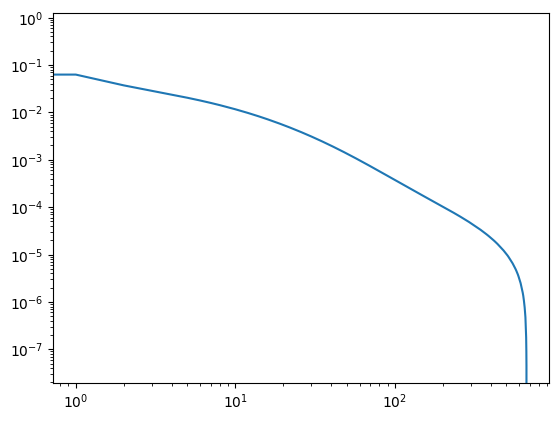

In [43]:
plt.plot(np.array(regularized_ls)-opt_val)
# plt.yscale("log")
plt.loglog()
plt.show()

Getting gradients closer to the objective, testing out if reclustering could in theory work

In [44]:
from cluster_tools import kmeans_pp_elbow

close_model = SimpleModel(clustered_data)
_ = train_model_until(close_model, 1e-4)
close_cluster_labels = kmeans_cos_elbow(get_grad(clustered_data, full_labels, close_model))
new_cluster_sampler = ClusterSampler(N, BATCH_SIZE, close_cluster_labels)

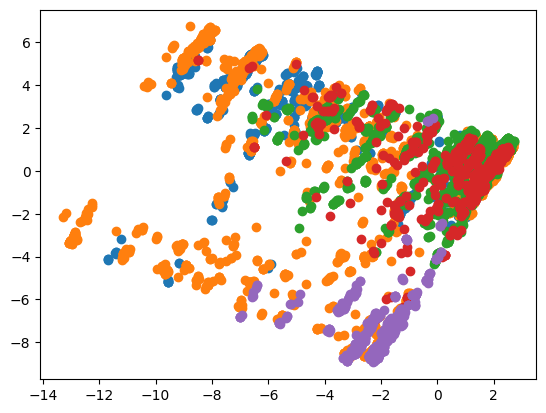

In [45]:
for i in range(new_cluster_sampler.cluster_count):
    selected = compressed_data[new_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

In [46]:
from solvers import solve_problem, svrg, COVER, clusterSVRG

In [47]:
from utils import clone_model

In [48]:
base_model = SimpleModel(clustered_data)
lr = 2
lr_one_t = lambda epoch: 5 / (epoch+1)
lr_log_t = lambda epoch: 5 * np.log(epoch+1) / (epoch+1)

In [49]:
cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cluster_sampler)
cosine_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cosine_cluster_sampler)

iid_sampler = RandomSampler(dataset, replacement=True)
iid_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=iid_sampler)

new_cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=new_cluster_sampler)

Clusters from linkage clustering

nb of clusters: 36
0.9960199004975124
0.0009045680687471732
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05
9.045680687471733e-05


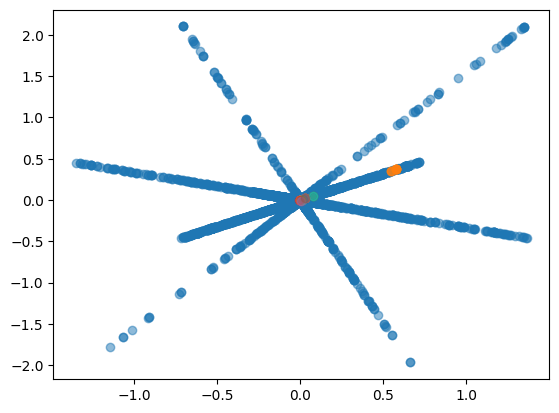

In [50]:
from cluster_tools import display_clusters, approx_nearest_clustering
from cluster_tools import alt_elbow

close_gradients = get_grad(clustered_data, full_labels, close_model)

# alt_cluster_labels = alt_elbow(labeled_data.detach().numpy())
alt_cluster_labels = approx_nearest_clustering(close_gradients)
alt_clusters = [[] for _ in range(max(alt_cluster_labels)+1)]
for i, j in enumerate(alt_cluster_labels):
    alt_clusters[j].append(i)

display_clusters(close_gradients, alt_cluster_labels, max(alt_cluster_labels)+1)

print("nb of clusters:", len(alt_clusters))
for c in alt_clusters:
    print(len(c)/N)

In [ ]:
from solvers import alt_solve_problem

# get number of thing per batch
v = np.zeros(len(alt_clusters))
for i in range(len(alt_clusters)):
    grads = np.mean(close_gradients[alt_clusters[i]], axis=0)
    v[i] = np.mean(np.sum((close_gradients[alt_clusters[i]] - grads)**2, axis=1))
v = torch.from_numpy(v)

_, alt_sol, _ = alt_solve_problem(base_model, 
                                  log_01_criterion,
                                  optimizer_class=torch.optim.SGD,
                                  datasource=dataset,
                                  cluster_labels=alt_cluster_labels,
                                  v_i=v,
                                  batch_size=BATCH_SIZE,
                                  n_epoch=200)

Both for comparison and for checking if the learning rate works

In [60]:
_, sgd_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
    n_epoch=NB_EPOCH,
    lr=lr,
    lr_lambda=lr_one_t,
    l2=LAMBDA
)

100%|██████████| 150/150 [00:26<00:00,  5.56it/s]


In [61]:
from solvers import full_batch_corresp

_, regular_gd_sol, _ = full_batch_corresp(
    clone_model(base_model, clustered_data),
    log_01_criterion,
    torch.optim.SGD,
    dataset,
    BATCH_SIZE,
    n_epoch=NB_EPOCH, 
    lr=lr,
    lr_lambda=lr_one_t,
    l2=LAMBDA
)

100%|██████████| 25950/25950 [00:16<00:00, 1609.88it/s]


In [62]:
opt_val = min(opt_val, min(sgd_sol))
opt_val = min(opt_val, min(regular_gd_sol))

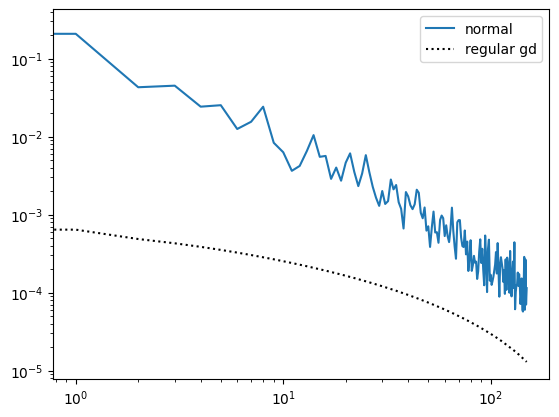

In [63]:
# plt.plot(alt_sol - opt_val, label="alt")
plt.plot(sgd_sol - opt_val, label="normal")
plt.plot(regular_gd_sol - opt_val, linestyle='dotted', color="black", label="regular gd")

plt.loglog()
plt.legend()
plt.show()

In [64]:
def repeat_exec(base_model,
                model_arg,
                criterion,
                optimizer_class,
                dataloader,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                verbose=True,
                repeat_times=REPEAT_TIMES,
                lr=lr,
                lr_lambda=lr_one_t,
                l2=LAMBDA):
    timestamps, sols = [], []
    for i in range(repeat_times):
        sgd_time, sgd_sol, _ = solve_problem(
            clone_model(base_model, model_arg), 
            criterion,
            optimizer_class,
            dataloader,
            n_epoch,
            time_lim,
            verbose,
            lr,
            lr_lambda,
            l2)
        timestamps.append(sgd_time)
        sols.append(sgd_sol)
    return timestamps, sols

In [31]:
# sgd_times, sgd_sols = repeat_exec(
#     base_model, clustered_data, 
#     log_01_criterion,
#     optimizer_class=torch.optim.SGD,
#     dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
#     n_epoch=1000,
#     repeat_times=1
    
# )
# plt.plot(sgd_sols[0]-opt_val, color="blue", label=None)
# plt.loglog()
# plt.show()

In [ ]:
svrg_time, svrg_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, BATCH_SIZE, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

In [ ]:
cover_time, cover_sol, _ = COVER(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

In [ ]:
clusterSVRG_time, clusterSVRG_sol, _ = clusterSVRG(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:34<320:36:28, 11.54s/it]


In [ ]:
grad_des_time, grad_des_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    regress_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, len(clustered_data)),
    n_epoch=NB_EPOCH,
    time_lim=TIME_LIM,
    verbose=True,
    lr=lr,
    # lr_lambda=lr_log_t,
    )

Building models...


  0%|          | 158/100000 [00:30<5:18:07,  5.23it/s]


In [65]:
from torch import Tensor

def display_grads(dataset:TensorDataset, model, cluster_sampler, alg="pca", title=""):
    dataset_torch, labels = dataset.tensors
    gradients = np.zeros_like(dataset_torch)
    lims = [0]
    for i in range(cluster_sampler.cluster_count):
        selected = dataset_torch[cluster_sampler.clusters[i]]
        selected_labels = labels[cluster_sampler.clusters[i]]
        grad_selected = get_grad(selected, selected_labels, model)
        # print(grad_selected)
        lims.append(lims[-1] + len(cluster_sampler.clusters[i]))
        gradients[lims[-2]:lims[-1], :] = grad_selected
    
    reduced = dimension_reduction(gradients, alg=alg)

    for i in range(cluster_sampler.cluster_count):
        plt.scatter(reduced[lims[i]:lims[i+1],0], reduced[lims[i]:lims[i+1],1], alpha=0.5)
    plt.title(title)
    plt.show()

In [ ]:
svrg_single_time, svrg_single_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:39<363:39:27, 13.09s/it]


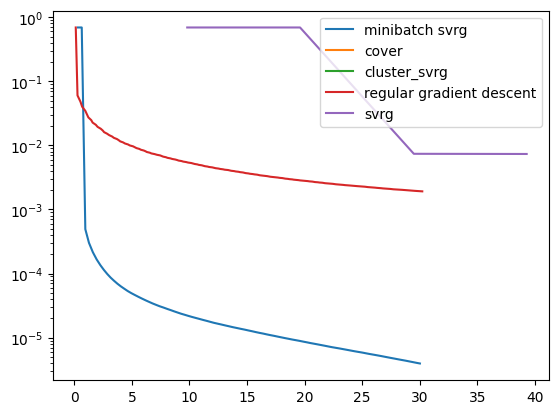

In [ ]:
plt.plot(svrg_time, svrg_sol-opt_val, label="minibatch svrg")
plt.plot(cover_time, cover_sol-opt_val, label="cover")
plt.plot(clusterSVRG_time, clusterSVRG_sol-opt_val, label="cluster_svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.plot(svrg_single_time, svrg_single_sol-opt_val, label="svrg")
plt.yscale("log")
plt.legend()
plt.show()

In [66]:
sgd_times, sgd_sols = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
)

Building models...


100%|██████████| 150/150 [00:27<00:00,  5.47it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.47it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.47it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.54it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.53it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.49it/s]


Building models...


100%|██████████| 150/150 [00:26<00:00,  5.58it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.54it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.51it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.54it/s]


In [ ]:
adam_time, adam_sol, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True,
              lr=lr,
              lr_lambda=lr_log_t)

In [ ]:
plt.plot(sgd_time, sgd_sol-opt_val, label="sgd")
plt.plot(adam_time, adam_sol-opt_val, label="adam")
plt.plot(svrg_time, svrg_sol-opt_val, label="svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.xlabel("time (s)")
plt.legend()
plt.yscale("log")
plt.show()

In [67]:
sgd_iid_times, sgd_sols_iid = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=iid_dataloader,
)

Building models...


100%|██████████| 150/150 [00:27<00:00,  5.42it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.46it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.45it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.49it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.50it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.46it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.44it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.48it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.48it/s]


Building models...


100%|██████████| 150/150 [00:27<00:00,  5.45it/s]


In [68]:
sgd_cluster_times, sgd_sols_cluster = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cluster_dataloader,
)

Building models...


100%|██████████| 150/150 [00:33<00:00,  4.42it/s]


Building models...


100%|██████████| 150/150 [00:34<00:00,  4.30it/s]


Building models...


100%|██████████| 150/150 [00:34<00:00,  4.34it/s]


Building models...


100%|██████████| 150/150 [00:34<00:00,  4.35it/s]


Building models...


100%|██████████| 150/150 [00:34<00:00,  4.32it/s]


Building models...


100%|██████████| 150/150 [00:34<00:00,  4.40it/s]


Building models...


100%|██████████| 150/150 [00:34<00:00,  4.30it/s]


Building models...


100%|██████████| 150/150 [00:34<00:00,  4.40it/s]


Building models...


100%|██████████| 150/150 [00:34<00:00,  4.37it/s]


Building models...


100%|██████████| 150/150 [00:34<00:00,  4.32it/s]


In [69]:
sgd_cosine_times, sgd_sols_cosine = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cosine_dataloader,
)

Building models...


100%|██████████| 150/150 [00:37<00:00,  3.95it/s]


Building models...


100%|██████████| 150/150 [00:37<00:00,  4.01it/s]


Building models...


100%|██████████| 150/150 [00:37<00:00,  3.98it/s]


Building models...


100%|██████████| 150/150 [00:37<00:00,  4.05it/s]


Building models...


100%|██████████| 150/150 [00:37<00:00,  3.99it/s]


Building models...


100%|██████████| 150/150 [00:36<00:00,  4.07it/s]


Building models...


100%|██████████| 150/150 [00:37<00:00,  3.97it/s]


Building models...


100%|██████████| 150/150 [00:37<00:00,  4.01it/s]


Building models...


100%|██████████| 150/150 [00:37<00:00,  4.03it/s]


Building models...


100%|██████████| 150/150 [00:37<00:00,  3.95it/s]


In [70]:
sgd_bis_times, sgd_bis = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=new_cluster_dataloader,
    # n_epoch=NB_EPOCH*20,
    # repeat_times=1
)

Building models...


100%|██████████| 150/150 [00:36<00:00,  4.16it/s]


Building models...


100%|██████████| 150/150 [00:35<00:00,  4.24it/s]


Building models...


100%|██████████| 150/150 [00:35<00:00,  4.25it/s]


Building models...


100%|██████████| 150/150 [00:35<00:00,  4.18it/s]


Building models...


100%|██████████| 150/150 [00:35<00:00,  4.21it/s]


Building models...


100%|██████████| 150/150 [00:35<00:00,  4.20it/s]


Building models...


100%|██████████| 150/150 [00:35<00:00,  4.19it/s]


Building models...


100%|██████████| 150/150 [00:35<00:00,  4.27it/s]


Building models...


100%|██████████| 150/150 [00:35<00:00,  4.25it/s]


Building models...


100%|██████████| 150/150 [00:35<00:00,  4.27it/s]


In [137]:
# from solvers import weighted_solver
# sgd_alt_cluster_t, sgd_alt_cluster, _ = weighted_solver(
#     clone_model(base_model, clustered_data), 
#     regress_criterion,
#     torch.optim.SGD,
#     dataset,
#     n_iter=None,
#     time_lim=TIME_LIM,
#     verbose=True
# )

In [138]:
# plt.plot(sgd_iid_time, sgd_sol_iid-opt_val, label="iid replaced", alpha=0.8)
# plt.plot(sgd_cluster_time, sgd_sol_cluster-opt_val, label="clustered", alpha=0.8)
# plt.plot(sgd_cosine_time, sgd_sol_cosine-opt_val, label="cosine", alpha=0.8)
# plt.plot(sgd_time, sgd_sol-opt_val, label="successive", alpha=0.8)

# plt.legend()
# plt.yscale("log")
# plt.xlabel("time (s)")
# plt.title("using SGD with different sampling techniques")
# plt.show()

In [ ]:
# folder = "./saves/"
# exp_type = "MNIST_01_" #"MNIST_01_"
# bis = "(3)"
# ext = "b" + str(BATCH_SIZE) + bis + ".txt"

In [ ]:
# execution_res_names = ["sgd_sols_iid", "sgd_sols_cluster", "sgd_sols_cosine", "sgd_sols"]
# file_names = ["sgd_iid_", "sgd_clustered_", "cosine_", ""]

In [46]:
# for ref, name in zip(execution_res_names, file_names):
#     exec(ref + " = np.loadtxt(folder + exp_type + name + ext)")

In [ ]:
# for ref, name in zip(execution_res_names, file_names):
#     exec("np.savetxt('" + folder + exp_type + name + ext + "', np.array(" + ref + "))")

In [71]:
for losses in [sgd_sols_iid, sgd_sols_cluster, sgd_sols_cosine, sgd_sols]:
    for l in losses:
        opt_val = min(opt_val, min(l))
opt_val

0.14230386912822723

In [72]:
def plot_mult_iter(losses, opt_val, color, label):
    ls = np.array(losses)
    # for l in losses:
        # plt.plot(l-opt_val, alpha=0.3, color=color)
    m = np.mean(ls, axis=0)
    std = np.std(ls, axis=0)
    l = len(m)
    plt.plot(m-opt_val, color=color, label=label, alpha=0.9)
    # plt.fill_between(np.arange(l), m-opt_val-std, m-opt_val+std, alpha=0.3)

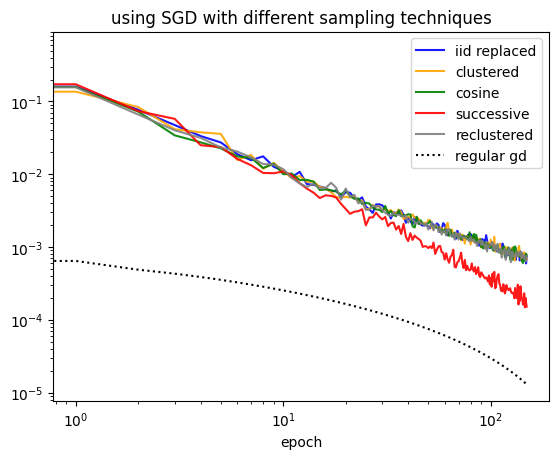

In [73]:
plot_mult_iter(sgd_sols_iid, opt_val, color="blue", label="iid replaced")
plot_mult_iter(sgd_sols_cluster, opt_val, color="orange", label="clustered")
plot_mult_iter(sgd_sols_cosine, opt_val, color="green", label="cosine")
plot_mult_iter(sgd_sols, opt_val, color="red", label="successive")
plot_mult_iter(sgd_bis, opt_val, color="grey", label="reclustered")
plt.plot(regular_gd_sol - opt_val, linestyle='dotted', color="black", label="regular gd")

plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("using SGD with different sampling techniques")
plt.show()

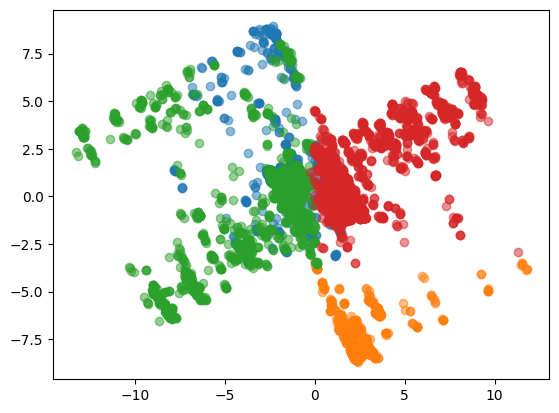

In [74]:
display_grads(dataset, SimpleModel(clustered_data), cluster_sampler)

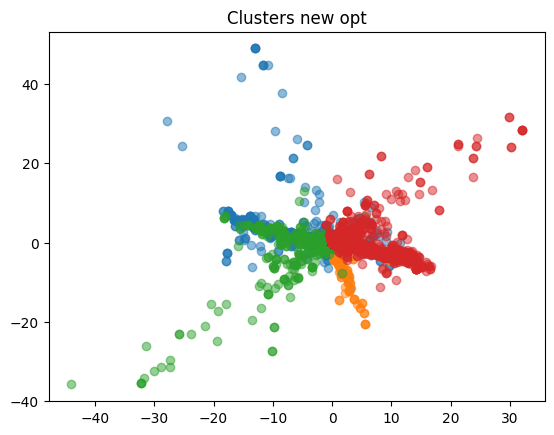

In [75]:
display_grads(dataset, model, cluster_sampler, title="Clusters new opt")

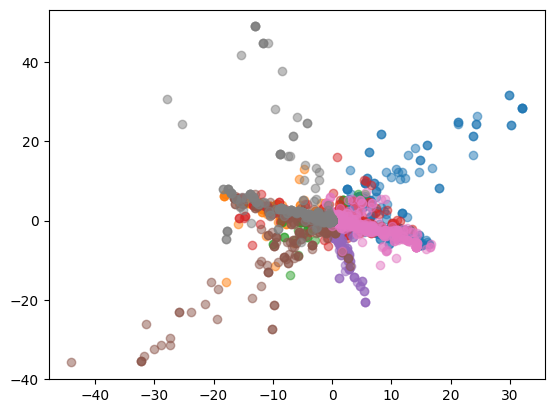

In [76]:
display_grads(dataset, model, cosine_cluster_sampler)

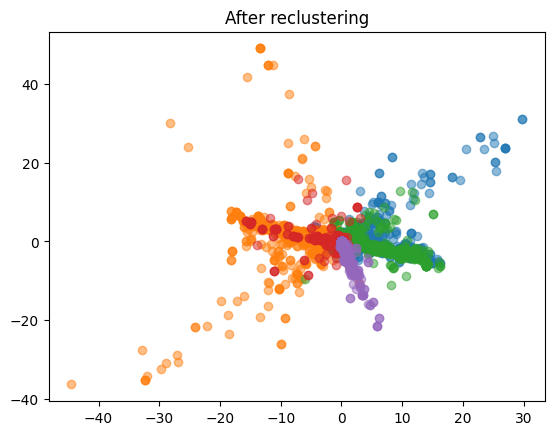

In [77]:
display_grads(dataset, close_model, new_cluster_sampler, title="After reclustering")

In [78]:
all_gradients = get_grad(clustered_data, full_labels, model)

In [79]:
def alt_objective(clusters, all_gradients):
    # objective function associated with the alternative "kmeans"
    #  from https://arxiv.org/abs/1405.3080
    res = 0
    n = len(all_gradients)
    for cluster in clusters:
        grads = np.mean(all_gradients[cluster], axis=0)
        res += np.sqrt(len(cluster)*np.sum((all_gradients[cluster] - grads)**2))
    return res / (n**2)

print(alt_objective(alt_clusters, all_gradients))
print(alt_objective(cluster_sampler.clusters, all_gradients))

0.00013566799200723267
0.00013186465484353732


In [80]:
from torch.utils.data import Sampler

# calculates the actual variance 
def batch_variance(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    grad = np.mean(batch_grads, axis=0)
    return np.mean(np.sum((batch_grads - grad)**2, axis=1))

full_dataset_var = batch_variance(clustered_data, full_labels, model)
print("full dataset variance:", full_dataset_var)

full dataset variance: 2.276589


In [81]:
def analyse_sampler(sampler:ClusterSampler, dataset:DataLoader, model, caption=None):
    if caption is not None:
        print(caption)
    batch_size = sum(sampler.sample_count) + sampler.added_count
    print("batch", batch_size, "added:", sampler.added_count)
    variances = np.zeros(sampler.cluster_count)
    for i, cluster in enumerate(sampler.clusters):
        batch, labels = dataset[cluster]
        variances[i] = batch_variance(batch, labels, model)
        print(sampler.cluster_sizes[i], 
              sampler.sample_count[i], 
              variances[i])
    avg = np.sum(variances*np.array(sampler.sample_count))/(batch_size - sampler.added_count)
    avg += sampler.added_count / sampler.num_samples * full_dataset_var
    print("average:", avg)

In [82]:
analyse_sampler(cluster_sampler, dataset, model, "Cluster variances")
analyse_sampler(cosine_cluster_sampler, dataset, model, "Cosine cluster variances")
analyse_sampler(new_cluster_sampler, dataset, model, "Recluster variances")

Cluster variances
batch 64 added: 3
2242 12 3.787205219268799
807 4 0.7865240573883057
3622 20 1.7019888162612915
4384 25 2.0726475715637207
average: 2.2046919706148467
Cosine cluster variances
batch 64 added: 6
1900 10 3.0563323497772217
1694 9 1.3723467588424683
969 5 1.2858811616897583
1180 6 3.134333848953247
791 4 0.785616934299469
1184 6 3.2211616039276123
2161 12 1.276964783668518
1176 6 3.2375917434692383
average: 2.1627600539066947
Recluster variances
batch 64 added: 2
2318 13 3.0211031436920166
3906 22 2.7937393188476562
2622 15 1.4263967275619507
1403 8 1.4789947271347046
806 4 0.7762352228164673
average: 2.2112095353540435


In [83]:
data, labels = cluster_dataloader.dataset.tensors
full_grad = np.mean(get_grad(data, labels, model), axis=0)

In [84]:
# checking the variance, see how much it's reduced...
def histogram(dataloader:DataLoader, full_grad=None, label=None):
    res = []

    if full_grad is None:
        data, labels = dataloader.dataset.tensors
        full_grad = np.mean(get_grad(data, labels, model), axis=0)

    print("calculating for {}".format(label))
    for _ in range(10):
        for (batch, labels) in dataloader:
            batch_grads = get_grad(batch, labels, model)
            res.append(np.sum((np.mean(batch_grads, axis=0) - full_grad)**2))
        res.pop() # the last batch is size n%batch_size which is usually not batch_size 
                  # so we exclude it
    return res
    # plt.hist(res, density=True, label=label, alpha=1, histtype="step")
    # return np.array(res)
    
res_iid = histogram(iid_dataloader, full_grad, "iid")
res_cluster = histogram(cluster_dataloader, full_grad, "cluster")
res_cos = histogram(cosine_dataloader, full_grad, "cosine")
res_successive = histogram(DataLoader(dataset, BATCH_SIZE), full_grad, "successive")
res_reclustered = histogram(new_cluster_dataloader, full_grad, "recluster")

calculating for iid
calculating for cluster
calculating for cosine
calculating for successive
calculating for recluster


In [85]:
for lab, res, color in zip(["iid","cluster", "cos", "successive", "reclus"],
                    [res_iid, res_cluster, res_cos, res_successive,res_reclustered],
                    ["blue", "orange", "green", "red", "gray"]):
    if len(res) == 1:
        r = res[0]
    else:
        r = res
    print(lab, np.mean(res)) # variances of the batches

iid 0.035046663
cluster 0.03469709
cos 0.03406895
successive 0.04054437
reclus 0.034130447


Is the variance the problem?

Note that if the variance is really negligible then convergence should look like regular gradient descent

In [56]:
def batch_sq_mean(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    return np.mean(np.sum(batch_grads**2, axis=1))

In [140]:
from torch.optim.lr_scheduler import LambdaLR

EXP_NB_EPOCH = 80
EXP_BATCH_SIZE = 64

m_gd = SimpleModel(clustered_data)
m_sgd = SimpleModel(clustered_data)

optim_gd = torch.optim.SGD(m_gd.parameters(), lr=1, weight_decay=LAMBDA)
schedul_gd = LambdaLR(optim_gd, lr_lambda=lr_one_t)

optim_sgd = torch.optim.SGD(m_sgd.parameters(), lr=1, weight_decay=LAMBDA)
schedul_sgd = LambdaLR(optim_sgd, lr_lambda=lr_one_t)
loader = DataLoader(dataset, batch_size=EXP_BATCH_SIZE, sampler=iid_sampler)

gd_losses = []
sgd_losses = []
var_over_time = []

for epoch in tqdm(range(EXP_NB_EPOCH)):
    for (batch, labels) in loader:
        # matching the number of iterations for full batch
        pred1 = m_gd(clustered_data)
        l1 = log_01_criterion(pred1, full_labels)
        optim_gd.zero_grad()
        l1.backward()
        optim_gd.step()
        # batches
        pred2 = m_sgd(batch)
        l2 = log_01_criterion(pred2, labels)
        optim_sgd.zero_grad()
        l2.backward()
        optim_sgd.step()
    variance = batch_variance(clustered_data, full_labels, m_sgd)/EXP_BATCH_SIZE #batch_sq_mean(clustered_data, full_labels, m_sgd)
    
    schedul_gd.step()
    gd_losses.append(get_regularized_loss(m_gd, 
                                          clustered_data, 
                                          full_labels,
                                          log_01_criterion,
                                          LAMBDA).item())

    schedul_sgd.step()
    var_over_time.append(variance)
    sgd_losses.append(get_regularized_loss(m_sgd, 
                                           clustered_data, 
                                           full_labels,
                                           log_01_criterion,
                                           LAMBDA).item())


100%|██████████| 80/80 [03:47<00:00,  2.84s/it]


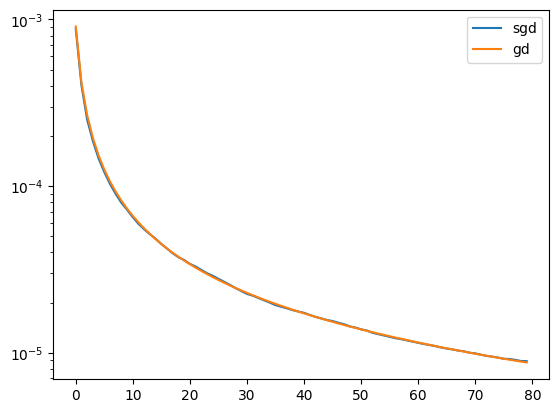

In [ ]:
plt.plot(np.array(sgd_losses)-opt_val, label="sgd")
plt.plot(np.array(gd_losses)-opt_val, label="gd")
plt.legend()
plt.loglog()
plt.show()

In [92]:
model_norm = 0
for p in model.parameters():
    model_norm += (p.data**2).sum()
model_norm = model_norm.item()
model_norm

74.69375610351562

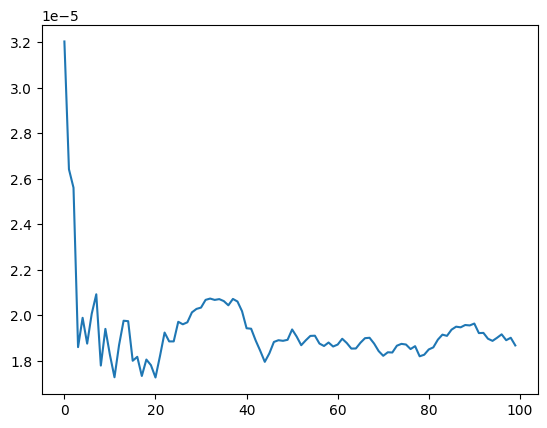

In [106]:
plt.plot(var_over_time)

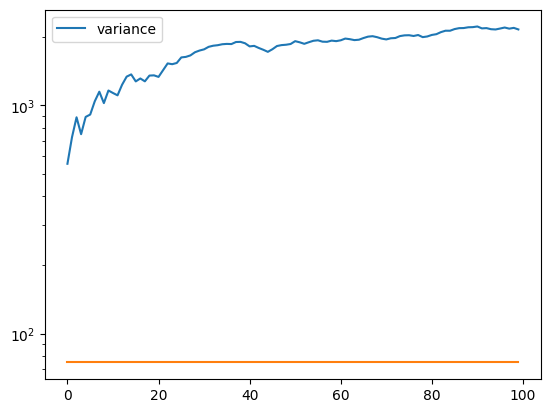

In [107]:
linspace = np.arange(EXP_NB_EPOCH)

plt.plot(np.log(linspace+2)*var_over_time/(2*LAMBDA)**2, label="variance")
plt.plot([model_norm]*EXP_NB_EPOCH)
plt.yscale("log")
plt.legend()
plt.show()

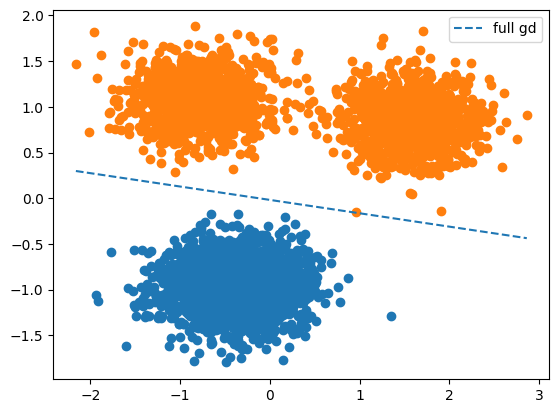

In [61]:
def plot_decision_boundary(data, model, label=None):
    w = model.layer.weight.detach().numpy().flatten()
    b = model.layer.bias.detach().item()
    x_vals = np.linspace(data[:,0].min(), data[:,0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, '--', label=label)
    else:
        # vertical line if w[1] == 0
        x_const = -b / w[0]
        plt.axvline(x_const, linestyle='--', label=label)

plot_decision_boundary(clustered_data, model, "full gd")
# plot_decision_boundary(clustered_data, test_m, "test")

plt.scatter(clustered_data[mask_0, 0], clustered_data[mask_0, 1])
plt.scatter(clustered_data[mask_1, 0], clustered_data[mask_1, 1])
plt.legend()
plt.show()

Testing sampler speed to seek for improvement

In [32]:
def test_sampler_speed(sampler):
    ITER_COUNT = 10
    dataloader = DataLoader(dataset, BATCH_SIZE, sampler=sampler)
    begin = time.perf_counter()
    for i in range(ITER_COUNT):
        for (batch, labels) in dataloader:
            pass
    end = time.perf_counter()
    print((end - begin)/ITER_COUNT)

In [ ]:
test_sampler_speed(None)
test_sampler_speed(RandomSampler(dataset))
test_sampler_speed(ClusterSampler(dataset, BATCH_SIZE, logistic_label_01_process))

0.1565863200000422
